# Post-Estimation Tutorial

In [1]:
%matplotlib inline

import pyblp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'1.1.0'

This tutorial covers several features of `pyblp` which are available after estimation including:

1. Calculating elasticities and diversion ratios.
2. Calculating marginal costs and markups.
3. Computing the effects of mergers: prices, shares, and HHI.
4. Using a parametric bootstrap to estimate standard errors.
5. Estimating optimal instruments.
6. Constructing optimal micro moments.


## Problem Results

As in the [fake cereal tutorial](nevo.ipynb), we'll first solve the fake cereal problem from [Nevo (2000a)](https://pyblp.readthedocs.io/en/stable/references.html#nevo-2000a). We load the fake data and estimate the model as in the previous tutorial. We output the setup of the model to confirm we have correctly configured the [`Problem`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.html#pyblp.Problem)

In [2]:
product_data = pd.read_csv(pyblp.data.NEVO_PRODUCTS_LOCATION)
agent_data = pd.read_csv(pyblp.data.NEVO_AGENTS_LOCATION)
product_formulations = (
   pyblp.Formulation('0 + prices', absorb='C(product_ids)'),
   pyblp.Formulation('1 + prices + sugar + mushy')
)
agent_formulation = pyblp.Formulation('0 + income + income_squared + age + child')
problem = pyblp.Problem(product_formulations, product_data, agent_formulation, agent_data)
problem

Dimensions:
 T    N     F    I     K1    K2    D    MD    ED 
---  ----  ---  ----  ----  ----  ---  ----  ----
94   2256   5   1880   1     4     4    20    1  

Formulations:
       Column Indices:           0           1           2      3  
-----------------------------  ------  --------------  -----  -----
 X1: Linear Characteristics    prices                              
X2: Nonlinear Characteristics    1         prices      sugar  mushy
       d: Demographics         income  income_squared   age   child

We'll solve the problem in the same way as before. The [`Problem.solve`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.solve.html#pyblp.Problem.solve) method returns a [`ProblemResults`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.html#pyblp.ProblemResults) class, which displays basic estimation results. The results that are displayed are simply formatted information extracted from various class attributes such as [`ProblemResults.sigma`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.html#pyblp.ProblemResults.sigma) and [`ProblemResults.sigma_se`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.html#pyblp.ProblemResults.sigma_se).

In [3]:
initial_sigma = np.diag([0.3302, 2.4526, 0.0163, 0.2441])
initial_pi = [
  [ 5.4819,  0,      0.2037,  0     ],
  [15.8935, -1.2000, 0,       2.6342],
  [-0.2506,  0,      0.0511,  0     ],
  [ 1.2650,  0,     -0.8091,  0     ]
]
results = problem.solve(
    initial_sigma,
    initial_pi,
    optimization=pyblp.Optimization('bfgs', {'gtol': 1e-5}),
    method='1s'
)
results

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 1    +4.6E+00   +6.9E-06     +4.4E-05        +1.6E+04        0         +6.9E+07          +8.4E+08     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:14       Yes          51           57          46380       143994   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy     |   Pi:      income    income_squared     age        child   
------  ----------  ----------  ----------  -------

Additional post-estimation outputs can be computed with [`ProblemResults`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.html#pyblp.ProblemResults) methods.


## Elasticities and Diversion Ratios

We can estimate elasticities, $\varepsilon$, and diversion ratios, $\mathscr{D}$, with [`ProblemResults.compute_elasticities`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_elasticities.html#pyblp.ProblemResults.compute_elasticities) and [`ProblemResults.compute_diversion_ratios`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_diversion_ratios.html#pyblp.ProblemResults.compute_diversion_ratios).

As a reminder, elasticities in each market are

$$\varepsilon_{jk} = \frac{x_k}{s_j}\frac{\partial s_j}{\partial x_k}.$$

Diversion ratios are

$$\mathscr{D}_{jk} = -\frac{\partial s_k}{\partial x_j} \Big/ \frac{\partial s_j}{\partial x_j}.$$

Following [Conlon and Mortimer (2018)](https://pyblp.readthedocs.io/en/stable/references.html#conlon-and-mortimer-2018), we report the diversion to the outside good $D_{j0}$ on the diagonal instead of $D_{jj}=-1$.

Post-estimation outputs are computed for each market and stacked. We'll use [matplotlib](https://matplotlib.org/) functions to display the matrices associated with a single market.

The diagonal of the first image consists of own elasticities and the diagonal of the second image consists of diversion ratios to the outside good. As one might expect, own price elasticities are large and negative while cross-price elasticities are positive but much smaller.

Elasticities and diversion ratios can be computed with respect to variables other than `prices` with the `name` argument of [`ProblemResults.compute_elasticities`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_elasticities.html#pyblp.ProblemResults.compute_elasticities) and [`ProblemResults.compute_diversion_ratios`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_diversion_ratios.html#pyblp.ProblemResults.compute_diversion_ratios). Additionally, [`ProblemResults.compute_long_run_diversion_ratios`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_long_run_diversion_ratios.html#pyblp.ProblemResults.compute_long_run_diversion_ratios) can be used to used to understand substitution when products are eliminated from the choice set.

The convenience methods [`ProblemResults.extract_diagonals`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.extract_diagonals.html#pyblp.ProblemResults.extract_diagonals) and [`ProblemResults.extract_diagonal_means`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.extract_diagonal_means.html#pyblp.ProblemResults.extract_diagonal_means) can be used to extract information about own elasticities of demand from elasticity matrices.

An alternative to summarizing full elasticity matrices is to use [`ProblemResults.compute_aggregate_elasticities`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_aggregate_elasticities.html#pyblp.ProblemResults.compute_aggregate_elasticities) to estimate aggregate elasticities of demand, $E$, in each market, which reflect the change in total sales under a proportional sales tax of some factor.

In [5]:
aggregates = results.compute_aggregate_elasticities(factor=0.1)

Since demand for an entire product category is generally less elastic than the average elasticity of individual products, mean own elasticities are generally larger in magnitude than aggregate elasticities.

## Marginal Costs and Markups

To compute marginal costs, $c$, the `product_data` passed to [`Problem`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.html#pyblp.Problem) must have had a `firm_ids` field. Since we included firm IDs when configuring the problem, we can use [`ProblemResults.compute_costs`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_costs.html#pyblp.ProblemResults.compute_costs).

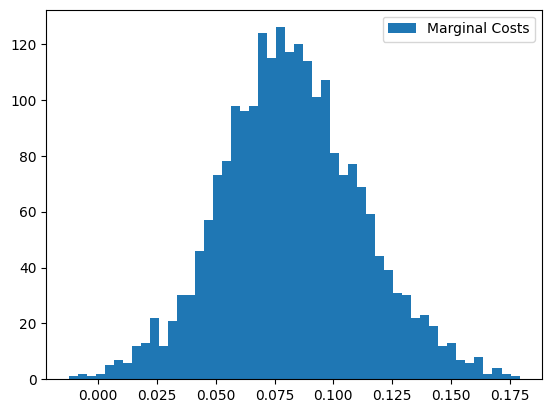

In [6]:
costs = results.compute_costs()
plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);

Other methods that compute supply-side outputs often compute marginal costs themselves. For example, [`ProblemResults.compute_markups`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_markups.html#pyblp.ProblemResults.compute_markups) will compute marginal costs when estimating markups, $\mathscr{M}$, but computation can be sped up if we just use our pre-computed values.

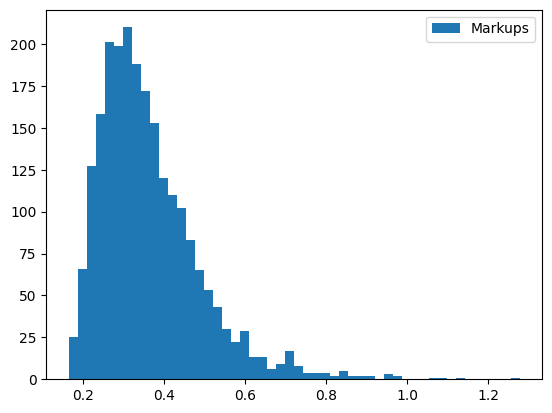

In [7]:
markups = results.compute_markups(costs=costs)
plt.hist(markups, bins=50);
plt.legend(["Markups"]);

## Mergers

Before computing post-merger outputs, we'll supplement our pre-merger markups with some other outputs. We'll compute Herfindahl-Hirschman Indices, $\text{HHI}$, with [`ProblemResults.compute_hhi`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_hhi.html#pyblp.ProblemResults.compute_hhi); population-normalized gross expected profits, $\pi$, with [`ProblemResults.compute_profits`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_profits.html#pyblp.ProblemResults.compute_profits); and population-normalized consumer surpluses, $\text{CS}$, with [`ProblemResults.compute_consumer_surpluses`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_consumer_surpluses.html#pyblp.ProblemResults.compute_consumer_surpluses).

In [1]:
hhi = results.compute_hhi()
profits = results.compute_profits(costs=costs)
cs = results.compute_consumer_surpluses()

To compute post-merger outputs, we'll create a new set of firm IDs that represent a merger of firms ``2`` and ``1``.

In [8]:
product_data['merger_ids'] = product_data['firm_ids'].replace(2, 1)

We can use [`ProblemResults.compute_approximate_prices`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_approximate_prices.html#pyblp.ProblemResults.compute_approximate_prices) or [`ProblemResults.compute_prices`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_prices.html#pyblp.ProblemResults.compute_prices) to estimate post-merger prices. The first method, which is in the spirit of early approaches to merger evaluation such as [Hausman, Leonard, and Zona (1994)](https://pyblp.readthedocs.io/en/stable/references.html#hausman-leonard-and-zona-1994) and [Werden (1997)](https://pyblp.readthedocs.io/en/stable/references.html#werden-1997), is only a partial merger simulation in that it assumes shares and their price derivatives are unaffected by the merger.

The second method, which is used by [Nevo (2000b)](https://pyblp.readthedocs.io/en/stable/references.html#nevo-2000b), is a full merger simulation in that it does not make these assumptions, and is the preferred approach to merger simulation. By default, we iterate over the $\zeta$-markup equation from [Morrow and Skerlos (2011)](https://pyblp.readthedocs.io/en/stable/references.html#morrow-and-skerlos-2011) to solve the full system of $J_t$ equations and $J_t$ unknowns in each market $t$. We'll use the latter, since it is fast enough for this example problem.

In [9]:
changed_prices = results.compute_prices(
    firm_ids=product_data['merger_ids'], 
    costs=costs
)

We'll compute post-merger shares with [`ProblemResults.compute_shares`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_shares.html#pyblp.ProblemResults.compute_shares).

In [10]:
changed_shares = results.compute_shares(changed_prices)

Post-merger prices and shares are used to compute other post-merger outputs. For example, $\text{HHI}$ increases.

In [11]:
changed_hhi = results.compute_hhi(
    firm_ids=product_data['merger_ids'],
    shares=changed_shares
)
plt.hist(changed_hhi - hhi, bins=50);
plt.legend(["HHI Changes"]);

NameError: name 'hhi' is not defined

Markups, $\mathscr{M}$, and profits, $\pi$, generally increase as well.

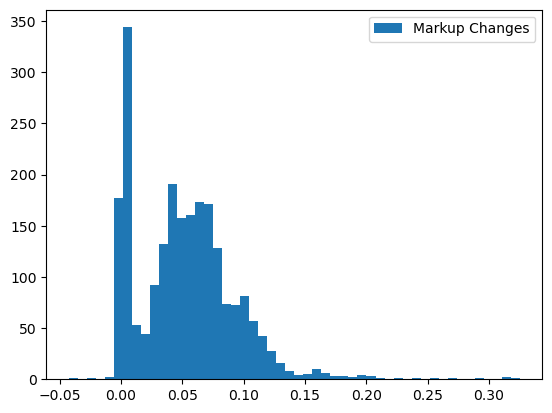

In [1]:
changed_markups = results.compute_markups(changed_prices, costs)
plt.hist(changed_markups - markups, bins=50);
plt.legend(["Markup Changes"]);

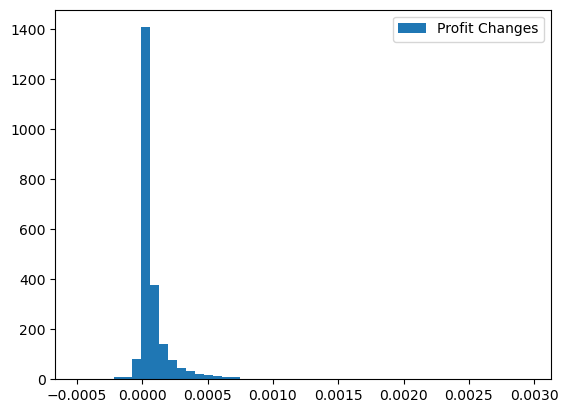

In [1]:
changed_profits = results.compute_profits(changed_prices, changed_shares, costs)
plt.hist(changed_profits - profits, bins=50);
plt.legend(["Profit Changes"]);

On the other hand, consumer surpluses, $\text{CS}$, generally decrease.

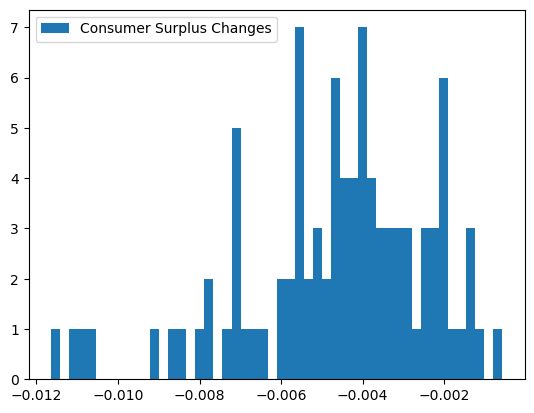

In [1]:
changed_cs = results.compute_consumer_surpluses(changed_prices)
plt.hist(changed_cs - cs, bins=50);
plt.legend(["Consumer Surplus Changes"]);

## Bootstrapping Results

Post-estimation outputs can be informative, but they don't mean much without a sense sample-to-sample variability. One way to estimate confidence intervals for post-estimation outputs is with a standard bootstrap procedure:

1. Construct a large number of bootstrap samples by sampling with replacement from the original product data.
2. Initialize and solve a [`Problem`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.html#pyblp.Problem) for each bootstrap sample.
3. Compute the desired post-estimation output for each bootstrapped [`ProblemResults`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.html#pyblp.ProblemResults) and from the resulting empirical distribution, construct boostrap confidence intervals.

Although appealing because of its simplicity, the computational resources required for this procedure are often prohibitively expensive. Furthermore, human oversight of the optimization routine is often required to determine whether the routine ran into any problems and if it successfully converged. Human oversight of estimation for each bootstrapped problem is usually not feasible.

A more reasonable alternative is a parametric bootstrap procedure:

1. Construct a large number of draws from the estimated joint distribution of parameters.
2. Compute the implied mean utility, $\delta$, and shares, $s$, for each draw. If a supply side was estimated, also computed the implied marginal costs, $c$, and prices, $p$.
3. Compute the desired post-estimation output under each of these parametric bootstrap samples. Again, from the resulting empirical distribution, construct boostrap confidence intervals.

Compared to the standard bootstrap procedure, the parametric bootstrap requires far fewer computational resources, and is simple enough to not require human oversight of each bootstrap iteration. The primary complication to this procedure is that when supply is estimated, equilibrium prices and shares need to be computed for each parametric bootstrap sample by iterating over the $\zeta$-markup equation from [Morrow and Skerlos (2011)](https://pyblp.readthedocs.io/en/stable/references.html#morrow-and-skerlos-2011). Although nontrivial, this fixed point iteration problem is much less demanding than the full optimization routine required to solve the BLP problem from the start.

An empirical distribution of results computed according to this parametric bootstrap procedure can be created with the [`ProblemResults.bootstrap`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.bootstrap.html#pyblp.ProblemResults.bootstrap) method, which returns a [`BootstrappedResults`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.BootstrappedResults.html#pyblp.BootstrappedResults) class that can be used just like [`ProblemResults`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.html#pyblp.ProblemResults) to compute various post-estimation outputs. The difference is that [`BootstrappedResults`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.BootstrappedResults.html#pyblp.BootstrappedResults) methods return arrays with an extra first dimension, along which bootstrapped results are stacked.

We'll construct 90% parametric bootstrap confidence intervals for estimated mean own elasticities in each market of the fake cereal problem. Usually, bootstrapped confidence intervals should be based on thousands of draws, but we'll only use a few for the sake of speed in this example.

In [1]:
bootstrapped_results = results.bootstrap(draws=100, seed=0)
bootstrapped_results

Bootstrapped Results Summary:
Computation  Bootstrap
   Time        Draws  
-----------  ---------
 00:00:09       100   

In [1]:
bounds = np.percentile(
    bootstrapped_results.extract_diagonal_means(
        bootstrapped_results.compute_elasticities()
    ), 
    q=[10, 90], 
    axis=0
)
table = pd.DataFrame(index=problem.unique_market_ids, data={
    'Lower Bound': bounds[0].flatten(), 
    'Mean Own Elasticity': means.flatten(), 
    'Upper Bound': bounds[1].flatten()
})
table.round(2).head()

,Lower Bound,Mean Own Elasticity,Upper Bound
C01Q1,-4.31,-4.21,-3.88
C01Q2,-4.07,-3.96,-3.68
C03Q1,-3.71,-3.40,-3.20
C03Q2,-3.65,-3.34,-3.16
C04Q1,-3.31,-3.15,-2.97


## Optimal Instruments

Given a consistent estimate of $\theta$, we may want to compute the optimal instruments of [Chamberlain (1987)](https://pyblp.readthedocs.io/en/stable/references.html#chamberlain-1987) and use them to re-solve the problem. Optimal instruments have been shown, for example, by [Reynaert and Verboven (2014)](https://pyblp.readthedocs.io/en/stable/references.html#reynaert-and-verboven-2014), to reduce bias, improve efficiency, and enhance stability of BLP estimates.

The [`ProblemResults.compute_optimal_instruments`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_optimal_instruments.html#pyblp.ProblemResults.compute_optimal_instruments) method computes the expected Jacobians that comprise the optimal instruments by integrating over the density of $\xi$ (and $\omega$ if a supply side was estimated). By default, the method approximates this integral by averaging over the Jacobian realizations computed under draws from the asymptotic normal distribution of the error terms. Since this process is computationally expensive and often doesn't make much of a difference, we'll use `method='approximate'` in this example to simply evaluate the Jacobians at the expected value of $\xi$, zero.

In [1]:
instrument_results = results.compute_optimal_instruments(method='approximate')
instrument_results

Optimal Instrument Results Summary:
Computation  Error Term
   Time        Draws   
-----------  ----------
 00:00:00        1     

We can use the [`OptimalInstrumentResults.to_problem`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.OptimalInstrumentResults.to_problem.html#pyblp.OptimalInstrumentResults.to_problem) method to re-create the fake cereal problem with the estimated optimal excluded instruments.

In [1]:
updated_problem = instrument_results.to_problem()
updated_problem

Dimensions:
 T    N     F    I     K1    K2    D    MD    ED 
---  ----  ---  ----  ----  ----  ---  ----  ----
94   2256   5   1880   1     4     4    14    1  

Formulations:
       Column Indices:           0           1           2      3  
-----------------------------  ------  --------------  -----  -----
 X1: Linear Characteristics    prices                              
X2: Nonlinear Characteristics    1         prices      sugar  mushy
       d: Demographics         income  income_squared   age   child

We can solve this updated problem just like the original one. We'll start at our consistent estimate of $\theta$.

In [1]:
updated_results = updated_problem.solve(
    results.sigma,
    results.pi, 
    optimization=pyblp.Optimization('bfgs', {'gtol': 1e-5}),
    method='1s'
)
updated_results

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 1    +8.0E-14   +3.0E-06     +1.6E-04        +2.9E+04        0         +7.8E+07          +1.8E+08     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:01:05       Yes          42           50          45902       142164   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy     |   Pi:      income    income_squared     age        child   
------  ----------  ----------  ----------  -------

## Optimal Micro Moments

Similarly, if we have micro data that links individual choices to demographics, we can use all the information in this data by constructing optimal micro moments that match the score of the micro data, evaluated at our consistent estimate of $\theta$. See the [micro moments tutorial](petrin.ipynb) for an introduction to constructing non-optimal micro moments.

We don't have actual micro data for this empirical example, but we can simulate some just to demonstrate how to construct optimal micro moments. We'll use the [`ProblemResults.simulate_micro_data`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.simulate_micro_data.html#pyblp.ProblemResults.simulate_micro_data) method to simulate 1,000 observations from a micro dataset at the estimated $\theta$. Like most micro datasets, we'll define `compute_weights` such that we only have observations from consumer who purchase an inside good $j \neq 0$. For simplicity, we'll assume we only have micro data from a single market, `'C61Q1'`. Again, see the [micro moments tutorial](petrin.ipynb) for a more in-depth discussion of [`MicroDataset`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.MicroDataset.html#pyblp.MicroDataset) and micro moments.

In [1]:
micro_dataset = pyblp.MicroDataset(
    name="Simulated micro data",
    observations=1_000,
    compute_weights=lambda t, p, a: np.ones((a.size, 1 + p.size)),
    market_ids=['C61Q1'],
)
micro_data = results.simulate_micro_data(
    dataset=micro_dataset,
    seed=0,
)

The simulated micro data are a record array, which can be difficult to visualize. We'll convert it to a pandas dataframe, which is what we would usually load from an actual micro dataset file.

In [1]:
micro_data = pd.DataFrame(pyblp.data_to_dict(micro_data))
micro_data

,micro_ids,market_ids,agent_indices,choice_indices
0,0,C61Q1,10,24
1,1,C61Q1,14,0
2,2,C61Q1,12,0
3,3,C61Q1,10,21
4,4,C61Q1,8,10
...,...,...,...,...
995,995,C61Q1,1,23
996,996,C61Q1,10,4
997,997,C61Q1,18,0
998,998,C61Q1,4,0


The simulated micro data contain four columns:

- `micro_ids`: This is simply an index from $0$ to $999$, indexing each micro observation.
- `market_ids`: This is the market of each observation. We configured our [`MicroDataset`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.MicroDataset.html#pyblp.MicroDataset)to only sample from one market.
- `agent_indices`: This is the within-market index (from $0$ to $I_t - 1$ in market $t$) of the agent data row that was sampled with probability $w_{it}$, configured by the `weights` column in agent data.
- `choice_indices`: This is the within-market index (from $0$ to $J_t - 1$ in market $t$) of the produt data row that was sampled with probability $s_{ijt}$ evaluated at the consistent estimate of $\theta$.

The simulated data contain a bit more information than we would usually have in actual micro data. The `agent_indices` contain information not only about observed demographics of the micro observation, but also about unobserved preferences. We will merge in only observed demographics for each agent index to get a more realistic simulated micro dataset.

In [1]:
agent_data['agent_indices'] = agent_data.groupby('market_ids').cumcount()
micro_data = micro_data.merge(
    agent_data[['market_ids', 'agent_indices', 'income', 'income_squared', 'age', 'child']],
    on=['market_ids', 'agent_indices']
)
del micro_data['agent_indices']
micro_data

,micro_ids,market_ids,choice_indices,income,income_squared,age,child
0,0,C61Q1,24,1.212283,22.546328,0.624306,-0.230851
1,3,C61Q1,21,1.212283,22.546328,0.624306,-0.230851
2,11,C61Q1,11,1.212283,22.546328,0.624306,-0.230851
3,28,C61Q1,10,1.212283,22.546328,0.624306,-0.230851
4,86,C61Q1,10,1.212283,22.546328,0.624306,-0.230851
...,...,...,...,...,...,...,...
995,937,C61Q1,0,0.636478,11.051747,-0.090347,-0.230851
996,952,C61Q1,5,0.636478,11.051747,-0.090347,-0.230851
997,954,C61Q1,14,0.636478,11.051747,-0.090347,-0.230851
998,971,C61Q1,13,0.636478,11.051747,-0.090347,-0.230851


This is more like real micro data that we would actually load from a file. For each observation, we know the market, choice, and demographics of the consumer.

To compute optimal micro moments at our consistent estimate of $\theta$, we need to compute two types of scores:

1. The score for each observation in our micro data via [`ProblemResults.compute_micro_scores`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_micro_scores.html#pyblp.ProblemResults.compute_micro_scores).
2. The score for each possible agent-choice in the model via [`ProblemResults.compute_agent_scores`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_agent_scores.html#pyblp.ProblemResults.compute_agent_scores).

For each, we will integrate over unobserved heterogeneity with quadrature, but one could use Monte Carlo methods too. We will do so by just passing an [`Integration`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Integration.html#pyblp.Integration) configuration to these two methods, but we could also do so by duplicating each row of micro data by as many integration nodes/weights we wanted for each, adding `weights` and `nodes` columns as with agent data.

In [1]:
score_integration = pyblp.Integration('product', 5)
micro_scores = results.compute_micro_scores(micro_dataset, micro_data, integration=score_integration)
agent_scores = results.compute_agent_scores(micro_dataset, integration=score_integration)

Both `micro_scores` and `agent_scores` are lists, with one element for each nonlinear parameter in $\theta$. The ordering is

In [1]:
results.theta_labels

['1 x 1',
 'prices x prices',
 'sugar x sugar',
 'mushy x mushy',
 '1 x income',
 '1 x age',
 'prices x income',
 'prices x income_squared',
 'prices x child',
 'sugar x income',
 'sugar x age',
 'mushy x income',
 'mushy x age']

The first element of `micro_scores` corresponds to the $\sigma$ on the constant term (i.e., the `'1 x 1'` above). It has the estimated score for each observation in `micro_data`:

In [1]:
micro_scores[0].shape

(1000,)

The first element of `agent_scores` also correspondds to the $\sigma$ on the constant term. It is a mapping from market IDs to arrays of scores for each of the $I_t \times J_t$ possible agent-choices in that market.

In [1]:
agent_scores[0]['C61Q1'].shape

(20, 25)

We will construct one optimal [`MicroMoment`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.MicroMoment.html#pyblp.MicroMoment) for each parameter, matching the average score (via a [`MicroPart`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.MicroPart.html#pyblp.MicroPart)) for that parameter from the micro data with its model counterpart.

In [1]:
optimal_micro_moments = []
for m, (micro_scores_m, agent_scores_m) in enumerate(zip(micro_scores, agent_scores)):
    optimal_micro_moments.append(pyblp.MicroMoment(
        name=f"Score for parameter #{m}",
        value=micro_scores_m.mean(),
        parts=pyblp.MicroPart(
            name=f"Score for parameter #{m}",
            dataset=micro_dataset,
            compute_values=lambda t, p, a, v=agent_scores_m: v[t],
        ),
    ))


For example, some information about the optimal micro moment for the first parameter is as follows.

In [1]:
optimal_micro_moments[0]

Score for parameter #0: -2.8E-02 (Score for parameter #0 on Simulated micro data: 1000 Observations in Market 'C61Q1')

Now, we can use our problem with updated optimal IVs, including our optimal micro moments, to obtain an efficient estimator.

In [1]:
updated_results = updated_problem.solve(
    results.sigma,
    results.pi, 
    optimization=pyblp.Optimization('bfgs', {'gtol': 1e-5}),
    method='1s',
    micro_moments=optimal_micro_moments,
)
updated_results

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 1    +1.1E+02   +8.8E-06     +2.3E-03        +8.3E+04        0         +2.2E+08          +4.1E+07     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:01:26       Yes          34           55          42977       133908   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy     |   Pi:      income    income_squared     age        child   
------  ----------  ----------  ----------  -------

Results are fairly similar to before because we simulated the micro data from our first-stage estimate of $\theta$, which was somewhat close to our second-stage estimate. Scores are not matched perfectly because the model is now over-identified, with two times as many moments as there are parameters (one optimal IV and one optimal micro moment for each nonlinear parameter).